In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 27.2 MB/s 
     |████████████████████████████████| 209 kB 47.9 MB/s 
     |████████████████████████████████| 81 kB 10.4 MB/s 
     |████████████████████████████████| 78 kB 9.0 MB/s 
     |████████████████████████████████| 112 kB 59.3 MB/s 
     |████████████████████████████████| 147 kB 70.3 MB/s 
     |████████████████████████████████| 49 kB 8.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=15c6ea7e3dae1fd98c0d8d71c5c5bb85e749346aa29ccfc9ceebb0486dd7e09a
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from torch.utils.data import Dataset , DataLoader 

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, Lambda, Compose
from torch import optim

from torch.utils.data.sampler import SubsetRandomSampler
# from pytorchtools import EarlyStopping

from tqdm import tqdm


torch.manual_seed (20)
np.random.seed(20)

In [ ]:
torch.manual_seed (20)
np.random.seed(20)



def dataset():
  transform = transforms.ToTensor()
  train_data = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transform)
  test_data  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transform)

  valid_size = 0.2
  batch_size = 256

  train = len(train_data)
  ind = list(range(train))
  
  np.random.shuffle(ind)
  split = int(np.floor(valid_size * train))
  train_idx, valid_idx = ind[split:], ind[:split]

  train_sampler = SubsetRandomSampler (train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx) 




  train_loader = DataLoader(train_data, sampler = train_sampler,batch_size = batch_size)
  valid_loader = DataLoader(train_data, sampler = valid_sampler ,batch_size = batch_size)

  test_loader = DataLoader(test_data, shuffle = False , batch_size = len(test_data))
  x_train , y_train = train_data.data, train_data.targets
  print('Shape of Training Data')
  print(x_train.shape , y_train.shape , sep='\n')

  
  print(f'\n Number of Training Samples : {len(train_idx)}')
  print(f' Number of Validation Samples : {len(valid_idx)}')

  print(f'Test Sample : {len(test_data)}')




# train_data = torchvision.datasets.FashionMNIST(root='./data', train=True ,download=True, transform = transforms.ToTensor())
# test_data = torchvision.datasets.FashionMNIST(root='./data', train=False ,download=True, transform = transforms.ToTensor())
# trainloader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)



  return train_loader, valid_loader, test_loader , x_train , y_train

train_loader, valid_loader, test_loader , x_train , y_train = dataset()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw

Shape of Training Data
torch.Size([60000, 28, 28])
torch.Size([60000])

 Number of Training Samples : 48000
 Number of Validation Samples : 12000
Test Sample : 10000


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is : {device}')

Available device is : cuda


SAMPLE AT INDEX 1
LABEL: 0


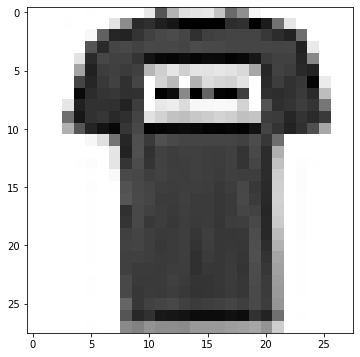

In [ ]:
sample_index = 1
image = x_train[sample_index]
label = y_train[sample_index]

fig = plt.figure(figsize=(6,6))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

In [ ]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


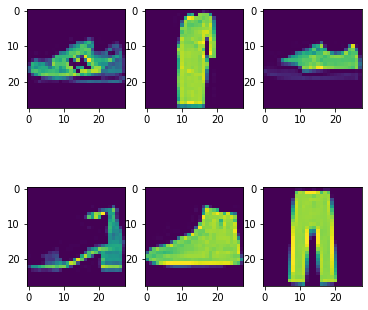

In [ ]:
images , label  = next(iter(train_loader))
fig  = plt.figure(figsize=(6,6))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(images[i][0])

plt.show()


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):


  def __init__(self, num_classes=10, dropout= 0 ):
      super(Classifier, self).__init__()
      self.layer1 = nn.Sequential(
          nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
      self.layer2 = nn.Sequential(
          nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
      self.fc = nn.Linear(7 * 7 * 32, num_classes)
      self.dropout = nn.Dropout(dropout)

  def forward(self, x):
      x = self.layer1(x)
      x = self.dropout(x)

      x = self.layer2(x)
      x = self.dropout(x)

      x = x.reshape(x.size(0), -1)
      x = self.fc(x)
      return x


# model = Classifier(10).to(device)
# print(model)

  def train_step(self, train_loader, criterion, optimizer):
    train_loss = []
    self.train()   
    
    for i, (image,label) in enumerate(train_loader):
        
        image = image.to(device)       
        labels = label.to(device)       
        
        predict = self.forward(image)      
        tr_loss = criterion(predict, labels) 
    
        self.zero_grad()                      
        tr_loss.backward()
        
        optimizer.step()                     
            
        ba_loss = tr_loss.detach().cpu().numpy()
        train_loss.append(ba_loss)            

    return train_loss
    

    

  def valid_step(self, valid_loader, criterion):
    val_loss = [] 
    self.eval()  
    
    with torch.no_grad():                         
        for s_batch in valid_loader:
            
            x_batch = s_batch[0].to(device)       
            label_b = s_batch[1].to(device)      
            for_out = self.forward(x_batch)      
            va_loss = criterion(for_out, label_b)

            ba_loss = va_loss.detach().cpu().numpy()
            val_loss.append(ba_loss)          
    
    return val_loss


  def train_fit(self, train_loader, valid_loader , criterion, device, epochs, params, optuna_st = False , early_stop = False) :
    val_loss_log = []
    train_loss_log = []

    if optuna_st == True:
      if params['optimizer']=='adam':

        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], 
                        weight_decay=params['reg_param'])
        
      elif params['optimizer']=='sgd':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], 
                      momentum=params['momentum'], weight_decay=params['reg_param'])
        
      elif  params['optimizer']=='RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'], 
                      momentum=params['momentum'], weight_decay=params['reg_param'])
    else :
      # optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], 
      #                 momentum=params['momentum'], weight_decay=params['reg_param'])
      optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], 
                             weight_decay= params ['reg_param'])

    for i in tqdm(range(epochs)):
      train_loss =  self.train_step(train_loader, criterion, optimizer)
      train_loss = np.mean(train_loss)
      train_loss_log.append(train_loss)

      valid_loss = self.valid_step( valid_loader, criterion)
      valid_loss = np.mean(valid_loss)
      val_loss_log.append(valid_loss)

      if early_stop :
        stop = self.early_stop(val_loss_log, epochs)
        if stop: 
            print('Early stopping at epoch ', i)
            params['epochs'] = i
            break
      
    return train_loss_log , val_loss_log


  def testing(self, criterion, test_loader):

    self.eval()  #set evaluation mode
    
    corrects  = 0.
    totals    = 0.
    test_loss = 0.
    
    with torch.no_grad():
        for s_batch in test_loader:
            
            x_batch = s_batch[0].to(device)      
            label_b = s_batch[1].to(device)       #import labels, move to device 
            
            outputs = self.forward(x_batch)
            
            test_loss += criterion(outputs, label_b).item()
            
            _, predicted = torch.max(outputs.data, 1)
            totals += label_b.size(0)
            corrects += (predicted == label_b).sum().item()
        
        accuracy = (corrects / totals) * 100
        avg_test_loss = test_loss / totals
        
        print("Loss on Test Dataset:",avg_test_loss, "\n Accuracy:",accuracy)
           
    return avg_test_loss, accuracy

  def early_stop(self, val_loss_stop, epochs):
        
    stop = False

    if len(val_loss_stop)>1:
        range_loss = min(len(val_loss_stop), 10)
        last_loss = val_loss_stop[-1]
        mean_loss = np.mean(val_loss_stop[-range_loss:-1])
        
        if (np.abs(last_loss-mean_loss) < 0.005): 
            stop = True
            
    return stop


model = Classifier().to(device)

In [ ]:
# epochs = 20
dropout = 0.2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.005)


params = {
      "epochs" : 30,
      "optimizer" : "adam",
      "momentum"      : 0.4,
      "learning_rate" : 1e-3,
      "reg_param"     : 0.005,


  }

 40%|████      | 12/30 [01:27<02:11,  7.28s/it]

Early stopping at epoch  12


<Figure size 432x288 with 0 Axes>

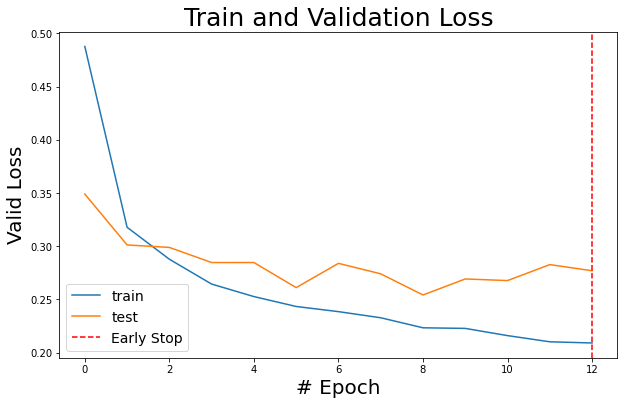

In [ ]:

train_loss,valid_loss = model.train_fit(train_loader=train_loader , valid_loader = valid_loader , 
                                        criterion = criterion,
                                        device = device, epochs = params['epochs'], params=params, 
                                        optuna_st = False , early_stop = True)

# train_loss,valid_loss

# Plot training results
plt.clf()
fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlabel('# Epoch', fontsize=20)
ax.set_ylabel('Valid Loss', fontsize=20)

ax.set_title('Train and Validation Loss', fontsize=25)
ax.plot(train_loss, label='train')
ax.plot(valid_loss, label='test')
ax.axvline(x=params['epochs'], linestyle ="--", color = 'r', label='Early Stop')
ax.legend(loc='best', fontsize=14)

plt.savefig('trv.png')
plt.show()

(16, 1, 5, 5)
(32, 16, 5, 5)


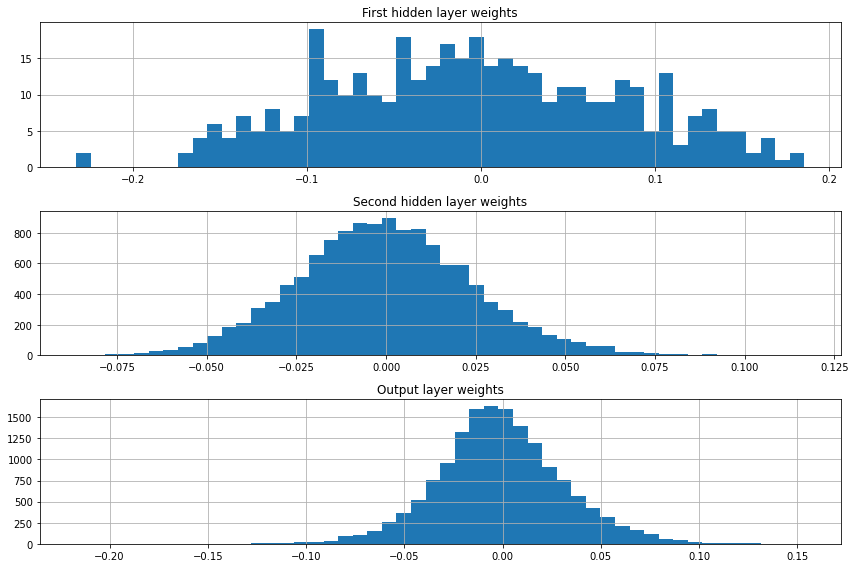

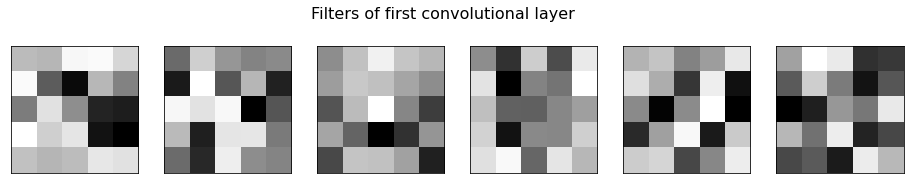

In [ ]:
def weights_dist(model):

  # First Convolutional layer
  conv1_w = model.layer1[0].weight.data.cpu().numpy()
  conv1_b =  model.layer1[0].bias.data.cpu().numpy()

  # Second Convolutional layer
  conv2_w =  model.layer2[0].weight.data.cpu().numpy()
  conv2_b =  model.layer2[0].bias.data.cpu().numpy()

  fc_w =  model.fc.weight.data.cpu().numpy()
  fc_b =  model.fc.bias.data.cpu().numpy()

  print(conv1_w.shape)
  print(conv2_w.shape)
  # print(fc_w)

  fig, axs = plt.subplots(3, 1, figsize=(12,8))
  axs[0].hist(conv1_w.flatten(), 50)
  axs[0].set_title('First hidden layer weights')
  axs[1].hist(conv2_w.flatten(), 50)
  axs[1].set_title('Second hidden layer weights')
  axs[2].hist(fc_w.flatten(), 50)
  axs[2].set_title('Output layer weights')
  [ax.grid() for ax in axs]
  plt.tight_layout()
  plt.savefig('wei.png')

  plt.show()


  fig, ax = plt.subplots(1,6, figsize=(16, 3))
  for i in range(6):
    ax[i].imshow( conv1_w[i, 0, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
  fig.suptitle('Filters of first convolutional layer', fontsize=16)
  plt.savefig('fil.png')
  plt.show()

  return conv1_w

conv1_w = weights_dist(model)

In [ ]:
def objective(trial):
  params = {
      "epochs" : 30, 
      "optimizer" : trial.suggest_categorical("optimizer", ["adam", "RMSprop", "sgd"]),
      "momentum"      : trial.suggest_float("momentum", 0.5, 0.7),
      "learning_rate" : trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True),
      "reg_param"     : trial.suggest_float("reg_param", 0.0001,0.0005),


  }


  # optim = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], 
  #                            weight_decay= params ['reg_param'])

  train_loss = model.train_fit(train_loader=train_loader , valid_loader = valid_loader , 
                               criterion = criterion, 
                               device = device, epochs = params['epochs'] ,
                               params= params,
                               optuna_st = True , early_stop = False)
  

  return np.mean(train_loss)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5, timeout=600)


print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Valuse of trial: ", trial.value)

print("  Best Parameter Found: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-09-03 20:42:44,817] A new study created in memory with name: no-name-543c7fbd-2ed4-4b7c-a205-8a7603500776
100%|██████████| 30/30 [02:59<00:00,  5.99s/it]
[I 2022-09-03 20:45:44,584] Trial 0 finished with value: 14.825803756713867 and parameters: {'optimizer': 'RMSprop', 'momentum': 0.6616688885552573, 'learning_rate': 0.09211528841506257, 'reg_param': 0.000499971978759105}. Best is trial 0 with value: 14.825803756713867.
100%|██████████| 30/30 [03:00<00:00,  6.01s/it]
[I 2022-09-03 20:48:44,749] Trial 1 finished with value: 0.8688367605209351 and parameters: {'optimizer': 'adam', 'momentum': 0.664601312696094, 'learning_rate': 3.229490085308725e-05, 'reg_param': 0.0003079826236568679}. Best is trial 1 with value: 0.8688367605209351.
100%|██████████| 30/30 [03:00<00:00,  6.00s/it]
[I 2022-09-03 20:51:44,837] Trial 2 finished with value: 0.6588460206985474 and parameters: {'optimizer': 'adam', 'momentum': 0.5242678787745982, 'learning_rate': 1.316217994978551e-05, 'reg_param': 0.

Number of finished trials: 4
Best trial:
  Valuse of trial:  0.5056657195091248
  Best Parameter Found: 
    optimizer: RMSprop
    momentum: 0.6748384169831029
    learning_rate: 2.5982593662383016e-05
    reg_param: 0.00032662487595234264


In [ ]:


# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))
print(trial.params)
best_model = trial.params
best_model['momentum']

{'optimizer': 'RMSprop', 'momentum': 0.6748384169831029, 'learning_rate': 2.5982593662383016e-05, 'reg_param': 0.00032662487595234264}


0.6748384169831029

In [ ]:

train_loss,valid_loss = model.train_fit(train_loader=train_loader , valid_loader = valid_loader , 
                                        criterion = criterion, 
                                        device = device, epochs = params['epochs'], params=best_model, 
                                        optuna_st = False ,early_stop = True)





100%|██████████| 12/12 [01:13<00:00,  6.12s/it]


<Figure size 432x288 with 0 Axes>

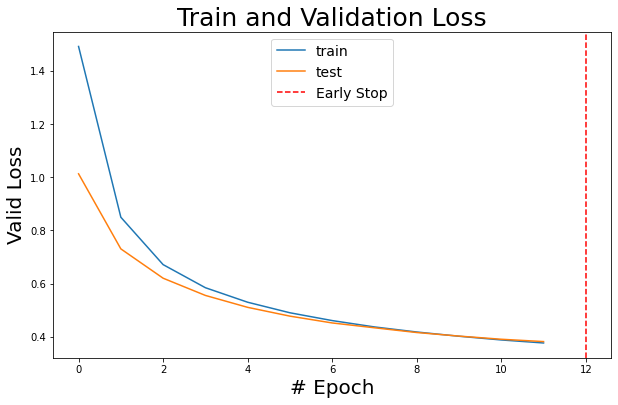

In [ ]:
# train_loss,valid_loss

# Plot training results
plt.clf()
fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlabel('# Epoch', fontsize=20)
ax.set_ylabel('Valid Loss', fontsize=20)

ax.set_title('Train and Validation Loss', fontsize=25)
ax.plot(train_loss, label='train')
ax.plot(valid_loss, label='test')
ax.axvline(x=params['epochs'], linestyle ="--", color = 'r', label='Early Stop')
ax.legend(loc='best', fontsize=14)

plt.savefig('best.png')
plt.show()

In [ ]:
model.testing( criterion, test_loader )

Loss on Test Dataset: 2.9877889156341554e-05 
 Accuracy: 89.39


(2.9877889156341554e-05, 89.39)